In [1]:
import os
try:
    from google.colab import drive
    drive.mount("/content/gdrive", force_remount=True)
    # cd gdrive/MyDrive/'Colab Notebooks'/Innovative-Approaches-to-Asset-Prediction/
    os.chdir("/content/gdrive/MyDrive/'Colab Notebooks'/Innovative-Approaches-to-Asset-Prediction/")
    print("Working on Google Colab...")
except:
    try:
        os.chdir(os.path.abspath(os.path.join(os.path.abspath(os.path.dirname(__vsc_ipynb_file__)), os.pardir)))
        print("Working on local machine...")
    except:
        print("Can't change directory. Quitting...")
        exit(1)

Working on local machine...


In [2]:
import datetime

from trading import backtest
from trading import calculate_metrics, \
                    weekly_returns, monthly_returns, \
                    distribution

Loading CSV files into DataFrames...
Loading CSV file for symbol 'EQ:SPY'...
Adjusting pricing in CSV files...
Adjusting CSV file for symbol 'EQ:SPY'...
Using pretrained model: 18989.US.RANDOM.30.5.64.3.RANGE.2.49
Initialising simulated broker "Backtest Simulated Broker Account"...
(2019-06-30 14:30:00+00:00) - portfolio creation: Portfolio "predictive_strategy" created at broker "Backtest Simulated Broker Account"
(2019-06-30 14:30:00+00:00) - subscription: 1000000.00 subscribed to portfolio "predictive_strategy"
Beginning backtest simulation...
(2019-07-01 14:30:00+00:00) - market_open
(2019-07-01 21:00:00+00:00) - market_close
(2019-07-02 14:30:00+00:00) - market_open
(2019-07-02 21:00:00+00:00) - market_close
(2019-07-03 14:30:00+00:00) - market_open
(2019-07-03 21:00:00+00:00) - market_close
(2019-07-04 14:30:00+00:00) - market_open
(2019-07-04 21:00:00+00:00) - market_close
(2019-07-05 14:30:00+00:00) - market_open
(2019-07-05 21:00:00+00:00) - market_close
(2019-07-05 21:00:00+0

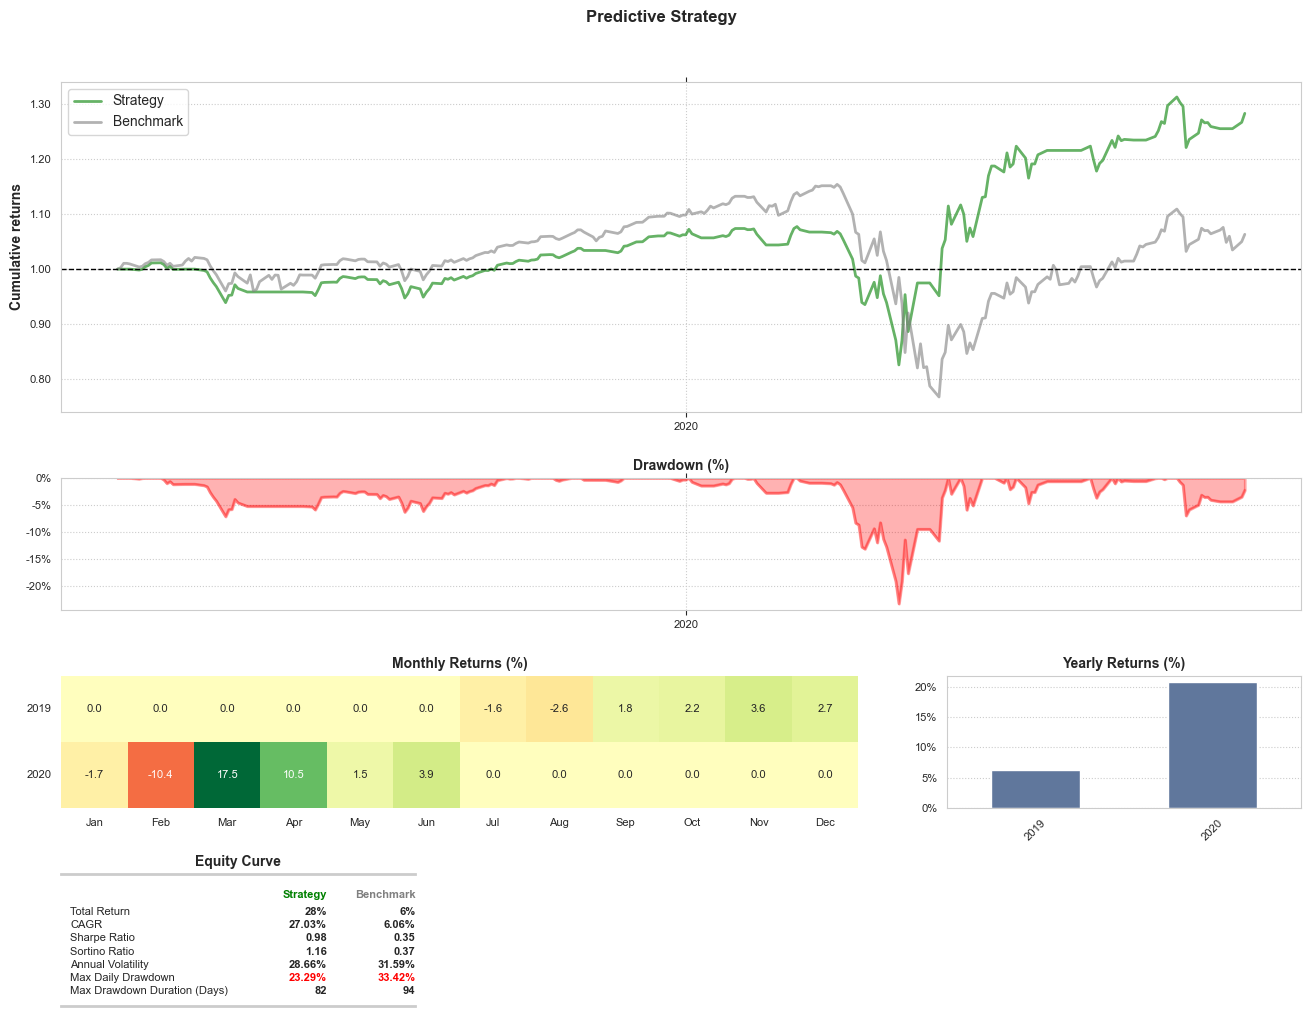

Backtest completed. Check the generated tearsheet for results.


In [3]:
csv_file = './data/unprocessed/SPY.csv'
initial_cash = 1_000_000    # $1,000,000 initial capital
lookback_period = 5         # Number of previous trading days to use for prediction

# Create a timestamped filename for the generated tearsheet
timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
filename = f'trading/backtest/results/predictive_strategy_backtest_{timestamp}.png'

# Run the backtest
tearsheet = backtest(csv_file, initial_cash, lookback_period,
                              start_dt="2019-06-30 14:30:00",
                              end_dt="2020-06-30 23:59:00",
                              model="18989.US.RANDOM.30.5.64.3.RANGE.2.49",
                              save_dir=filename)

print("Backtest completed. Check the generated tearsheet for results.")

In [4]:
# Calculate and display the strategy metrics
strategy_returns = tearsheet.strategy_equity
benchmark_returns = tearsheet.benchmark_equity

In [5]:
strategy_statistics = tearsheet.get_results(strategy_returns)
benchmark_statistics = tearsheet.get_results(benchmark_returns)

<Axes: title={'center': 'Strategy Growth Over Benchmark'}>

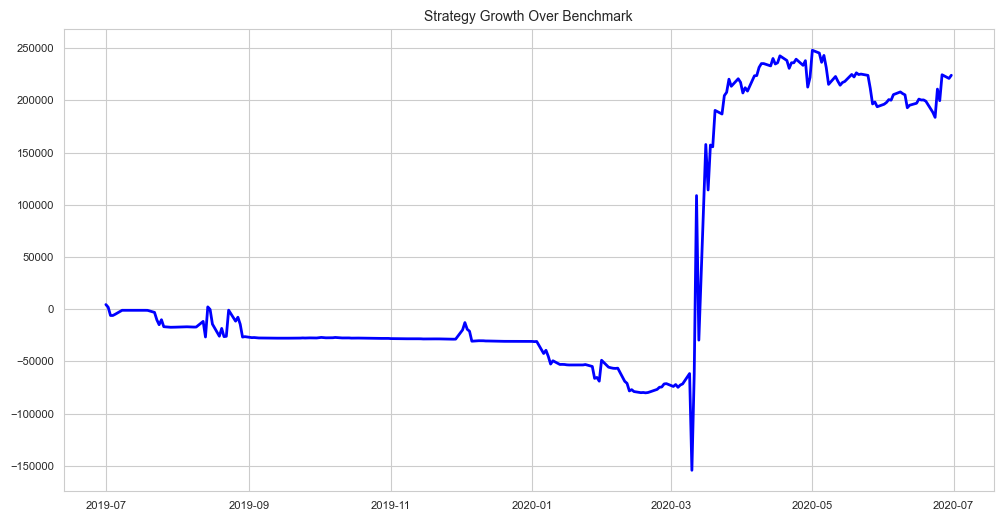

In [6]:
# Plot the growth of the strategy over the benchmark
growth = strategy_statistics['equity'] - benchmark_statistics['equity']
growth.plot(title='Strategy Growth Over Benchmark', figsize=(12, 6), color='blue', lw=2)

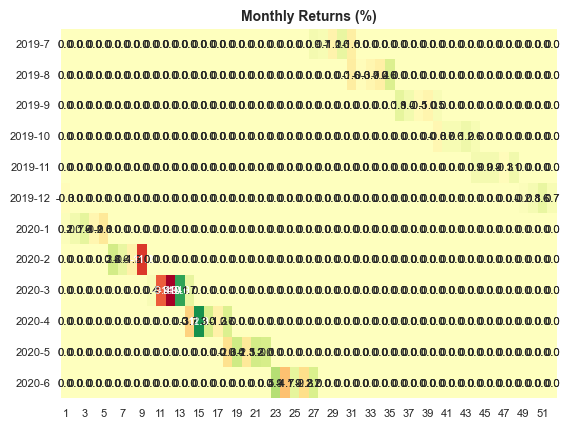

In [7]:
strategy_weekly_returns = weekly_returns(strategy_statistics)
benchmark_weekly_returns = weekly_returns(benchmark_statistics)

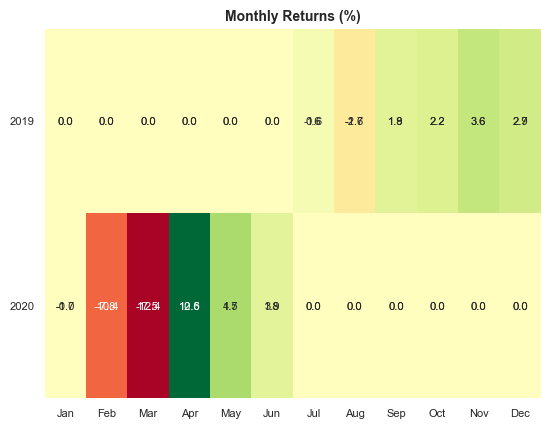

In [8]:
strategy_monthly_return = monthly_returns(strategy_statistics)
benchmark_monthly_returns = monthly_returns(benchmark_statistics)

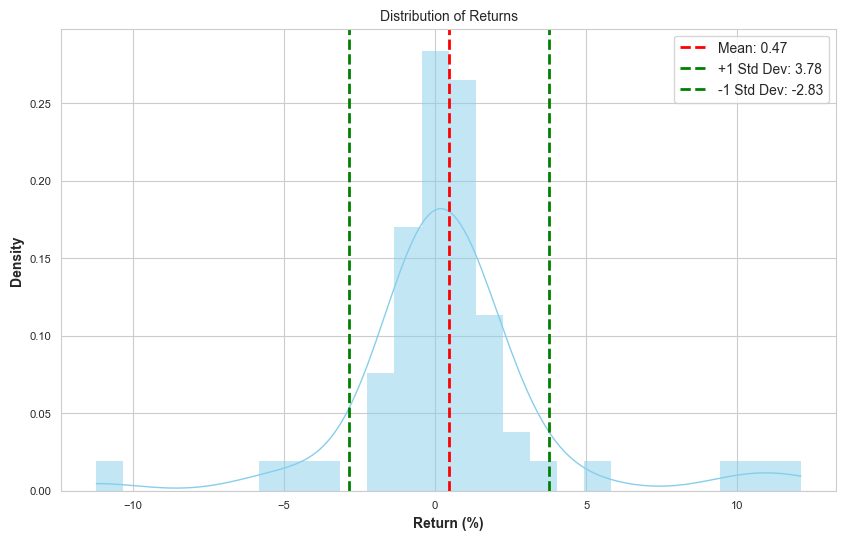

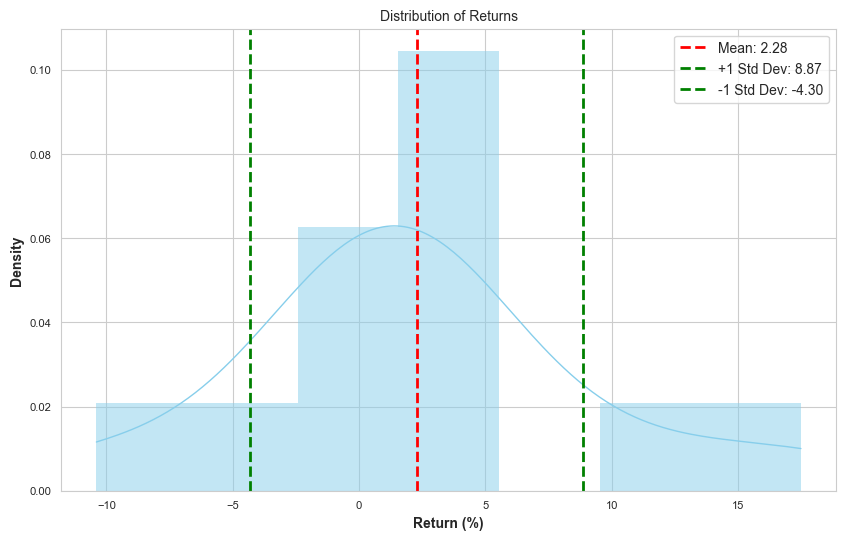

In [9]:
# Display the distribution of weekly and monthly returns of the strategy
distribution(strategy_weekly_returns)
distribution(strategy_monthly_return)

In [10]:
# Calculate the alpha, beta, and information ratio of the strategy
metrics = calculate_metrics(strategy_statistics["returns"], benchmark_statistics["returns"], 0)

print(f"Ann. Alpha: {100*metrics['alpha']:.2f}%")
print(f"Beta: {metrics['beta']:.2f}")
print(f"Ann. Information Ratio: {metrics['information_ratio']:.2f}")

Ann. Alpha: 25.36%
Beta: 0.24
Ann. Information Ratio: 0.47
